# Handling LEFTfield chains with 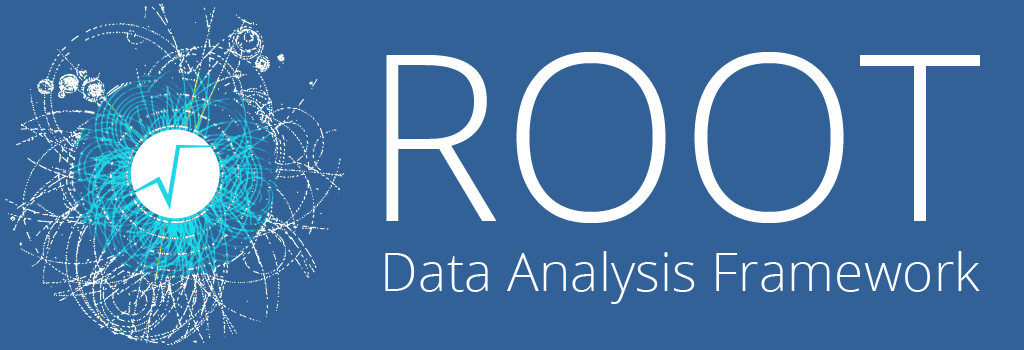

For Bayesian inference using Monte-Carlo-Markov-Chain (MCMC) sampling, if the problem is high `N`-dimensional, e.g. `N>=1E5-1E6`, the input data vector and output model prediction vector will be of order `N`, making each MCMC sample output a large array. Popular large-array containers like `HDF5` is not always I/O friendly. For example they cannot be read/synced during I/O. Furthermore, looking up and traversing large `HDF5` files can be time consuming.

This is the case for our upcoming Field-level Bayesian Inference (FBI) code `LEFTfield` that analyzes the clustering of galaxies directly at the three-dimensional field level. Such a data vector can reach `N>=1E5-1E7`. For such cases, CERN `root` format provides a very convenient hierachical storage structure that supports simultaneous reading/syncing+writing. See, e.g. this the discussion in this [thread](https://root-forum.cern.ch/t/root-file-vs-hdf5/20115/2).

This is a tutorial of how to handle [LEFTfield](https://gitlab.mpcdf.mpg.de/leftfield/release/leftfield) chain output with [pyROOT](https://root.cern/manual/python/), from `.root` files to `getdist.MCSamples`.

For [Jupyter](https://jupyter.org/) `.ipynb` examples of how to handle chain output in `.hdf5` format, follow [this URL](https://gitlab.mpcdf.mpg.de/leftfield/leftfield_devel/-/tree/minh/dask_example/jupyter_notebook_examples) instead.

All errors are mine. I can be reached [HERE](mailto:nhat.minh.nguyen.111@gmail.com).

## Required modules

In [ ]:
import ROOT
import os, glob
from itertools import chain
from pathlib import Path
import numpy as np

from getdist import MCSamples,loadMCSamples,plots

## Data path & key

Adapt the path below to your path.

For our analyses, we usually need to run the inference on data at multiple redshift `z_snaps`, with various analysis choices, including `Lambda_values,kmax_values,NGeul_values`. We further need to run at least 3 MCMC chains for each inference, to check for convergence and increase MCMC effective sample size after convergence.

Therefore, we end up with multiple of chain triplets, with each triplet contains 3 chains for the same analysis, while each individual chain contains multiple batches of MCMC samples. (Usually each batch consists all outputs from the same day.)

Below, I collect all chains, for each chain gather all batches, and finally sort chains into triplets.

In [ ]:
z_snaps=['0.0','0.5']
chain_paths=['/freya/ptmp/mpa/fabians/SNG/HMC/production/ada/lM12.5-14.0_z'+z_snap+'_NUFFT256' for z_snap in z_snaps]
Lambda_values=['0.12','0.14']
kmax_values=['0.10','0.12']
NGeul_values=['96','116']
chain_prefixes=['TPIretestL','RPI_stage3_L']
chain_suffixes=['','A_','B_']
chain_prefixes_suffixes=list(product(chain_prefixes,chain_suffixes))
chain_prefixes_suffixes=[(prefix, suffix) for prefix, suffix in chain_prefixes_suffixes\
                         if not (prefix == 'TPIretestL' and suffix in ['A_', 'B_'])
                         and not (prefix == 'RPI_stage3_L' and suffix == '')
                        ]                     
chain_name_combinations = list(product(chain_prefixes_suffixes, zip(Lambda_values, kmax_values, NGeul_values)))
# Define a custom sorting key using a lambda expression
chain_name_sort_key = lambda item: (
    item[1][0], item[1][1], item[1][2], chain_prefixes.index(item[0][0]), chain_suffixes.index(item[0][1])
)

# Sort the combined list using the custom key
sorted_chain_name_combinations = sorted(chain_name_combinations, key=chain_name_sort_key)
chain_names = [
    f"{prefix}{Lambda}kmax{kmax}_2LPT3D-NUFFT_fourierlike_NGeul{NGeul}_cubesphereNGlike63_sigmalim_{suffix}"\
    for (prefix,suffix), (Lambda, kmax, NGeul) in sorted_chain_name_combinations
]
chain_list = [
    os.path.join(chain_path, chain_name)\
    for chain_path, chain_name in list(product(chain_paths,chain_names))
]
kmax_value_list = [float(chain_name.split('kmax')[1].split('_')[0]) for chain_name in chain_list]
chain_list=[chain_list[i:i + 3] for i in range(0, len(chain_list), 3)]

## Handlers

In [ ]:
# Chain handler to sort and combine multiple ROOT files
class ROOTChainHandler:
    def __init__(self, chain_path, single_chain=True):
        self.chain_path = chain_path
        self.chain_batches = []
        self.single_chain = single_chain
        
    def find_and_sort_chain_batches(self,batch_path):
        path = Path(os.path.split(batch_path)[0])
        self.chain_batches.append(sorted(path.glob(os.path.split(batch_path)[1]+'[0-9]*.root'),\
            key=lambda p: int(p.stem.rsplit(os.path.split(batch_path)[1], 1)[1])))
    
    def process_files(self):
        if self.single_chain is True:
            try:
                self.find_and_sort_chain_batches(self.chain_path)
            except TypeError as err:
                raise TypeError("If ``single_chain`` is True, ``chain_path`` must be a 'str', not a 'list'.") from err
        else:
            for chain_batches in self.chain_path:
                for chain_batch in chain_batches:
                    self.find_and_sort_chain_batches(chain_batch)

    def get_batch(self):
        if not self.chain_batches:
            self.process_files()
        return self.chain_batches

# File handler to extract parameters from individual ROOT files
class ROOTFileHandler:
    def __init__(self, file_name, tree_name):
        self.file_name = file_name
        self.tree_name = tree_name
        self.file = None
        self.tree = None
        self.branches = []
        self.branch_leaves = []
        self.leaf_values = []
        self.leaf_weights = None

    def process_file(self):
        self.open_file()
        self.traverse_tree()
        self.close_file()
    
    def open_file(self):
        if self.file_name:
            self.file = ROOT.TFile.Open(self.file_name, "READ")

    def close_file(self):
        if self.file:
            self.file.Close()

    def traverse_tree(self):
        if self.file is None:
            try:
                self.open_file()
            except FileNotFoundError as err:
                raise FileNotFoundError("Cannot open ROOT file. Check chain path.") from err
        else:
            key = self.file.GetKey(self.tree_name)
            if key:
                self.tree = key.ReadObj()
                branches = self.tree.GetListOfBranches()

                for branch in branches:
                    branch_name = branch.GetName()
                    leaves = []
                    leaf_values_branch = []
                    self.branches.append(branch_name)
                    self.branch_leaves.append(leaves)

                    branch_ptr = self.tree.GetBranch(branch_name)
                    leaf_count = branch_ptr.GetListOfLeaves().GetEntries()

                    for i in range(leaf_count):
                        leaf = branch_ptr.GetLeaf(branch_ptr.GetListOfLeaves().At(i).GetName())
                        leaf_name = leaf.GetName()
                        leaves.append(leaf_name)
                        leaf_values_branch.append(np.zeros(self.tree.GetEntries()))

                        for entry in range(self.tree.GetEntries()):
                            self.tree.GetEntry(entry)
                            branch_ptr.GetEntry(entry)
                            leaf_value = leaf.GetValue()
                            leaf_values_branch[i][entry]=leaf_value
                            
                    self.leaf_values.append(leaf_values_branch)
                    
                self.leaf_values = np.array(self.leaf_values)
            else:
                raise KeyError("Key not found.")

    def show_branch(self):
        print("List of branches:")
        for b, branch in enumerate(self.branches):
            print(f"Branch {b + 1}: {branch}")

    def get_branch_list(self):
        if not self.branches:
            self.process_file()
        return self.branches

    def show_leaf(self):
        print("List of leaves:")
        for l, leaf in enumerate(self.branch_leaves):
            print(f"Leaf {l + 1}: {leaf}")
        if self.leaf_values.size > 0:
            print("\nShape of leaves as a Numpy array:")
            print(self.leaf_values.shape)
            print("\nValues stored in leaves:")
            print(self.leaf_values)
        else:
            warnings.warn("No value found in leaves.", UserWarning)

    def get_leaf_list(self):
        if self.branch_leaves == []:
            self.process_file()
        return self.branch_leaves

    def get_leaf_value(self):
        if self.leaf_values == []:
            self.process_file()
        return np.squeeze(self.leaf_values)

# Chain packer to pack sample parameters into a GetDist MCSamples object
class ChainPacker:
    def __init__(self,param_labels,param_values,chain_settings=None,sample_weights=None):
        self.weighted_samples = None
        self.param_values = param_values
        self.chain_settings = chain_settings
        self.sample_weights = sample_weights
        self.param_latex_labels = []
        self.param_labels = param_labels
        if (len(self.param_labels) != self.param_values[2:,:].shape[0]):
            raise IndexError("Number of parameters and number of parameter labels do not match.")
        self.latex_label_dict = {
            'alpha': r'\alpha',
            'b1': r'b_\delta',
            'b_lapldelta': r'b_{\nabla^2 \delta}',
            'b_lapldelta2': r'b_{\nabla^2 \delta^2}',
            'b_laplK2': r'b_{\nabla^2 K^2}',
            'b_lapl_lapldelta': r'b_{\nabla^4 \delta}',
            'b_sigmasigma': r'b_{(\mathrm{tr}[M^{(1)}])^2}',
            'b_sigmasigmasigma': r'b_{(\mathrm{tr}[M^{(1)}])^3}',
            'b_sigmatrM1M1': r'b_{\mathrm{tr}[(M^{(1)})^2]\mathrm{tr}[M^{(1)}]}',
            'b_trM1M1M1': r'b_{\mathrm{tr}[(M^{(1)})^3]}',
            'b_trM1M1' : r'b_{\mathrm{tr}[(M^{(1)})^2]',
            'b_trM1M2' : r'b_{\mathrm{tr}[M^{(1)}M^{(2)}]}',
            'b_K2' : r'b_{K^2}',
            'b_K3' : r'b_{K^3}',
            'b_Otd' : r'b_{\mathrm{Otd}}',
            'b_delta2' : r'b_{\delta^2}',
            'b_deltaK2' : r'b_{\delta K^2}',
            'b_delta3' : r'b_{\delta^3}',
            'sigma' : r'\sigma_\epsilon',
            'sigmaEpsk2' : r'\sigma_{\epsilon_{k^2}}',
            'sigmaEpsk4' : r'\sigma_{\epsilon_{k^4}}'
}
        for label in self.param_labels:
            if label not in self.latex_label_dict:
                raise KeyError(f"Parameter label '{label}' cannot be found in the latex label dict.")

    def get_param_latex_labels(self):
        if len(self.param_latex_labels) > 0:
            self.param_latex_labels = []
        for label in self.param_labels:
            self.param_latex_labels.append(self.latex_label_dict[label])

    def get_MCSamples(self):
        if len(self.param_latex_labels) == 0:
            self.get_param_latex_labels()
        return MCSamples(samples=self.param_values[2:,:].T,\
                         names=self.param_labels,labels=self.param_latex_labels,\
                         weights=self.sample_weights,loglikes=self.param_values[1,:],\
                         settings=self.chain_settings)

## Examples

### Loading and packing chains

We first load and sort chain batches.

Note that if you want to pass a list of chains, instead of an individual chain, ``single_chain=False`` must be specified. Otherwise an error will be raised. (Try uncomment and evaluate the cell below!)

In [ ]:
chain_handler = ROOTChainHandler(chain_list,single_chain=False)

Remember to set `single_chain=True` for the case of a single input chain.

In [ ]:
#chain_handler = ROOTChainHandler(chain_list,single_chain=True)

You can check the number of chains `ROOTChainHandler` found and their order like this.

In [ ]:
chains=chain_handler.get_batch()
print(len(chains))

Now we load the chain and extract parameter values from its samples.

In [ ]:
param_values=[]
tree_name='bias'
for chain in chains:
    
    stacked_params = []
    for batch in chain:
        file_handler = ROOTFileHandler(str(batch), tree_name) #TFile.Open only accepts input ``filename`` as 'str'
        stacked_params.append(file_handler.get_leaf_value())
    stacked_params_chain = np.concatenate(stacked_params,axis=1)
    
    param_values.append(stacked_params_chain)

You can further inspect the number of parameters and samples found in each chain like this.

In [ ]:
for c,chain_param_values in enumerate(param_values):
    print(f"Found {param_values[c].shape[0]} parameters and {param_values[c].shape[1]} samples in chain {c+1}.")

You can check the list of parameter names like this.

In [ ]:
param_name_list=file_handler.get_branch_list()
print(param_name_list)
param_name_list=param_name_list[2:]
print(param_name_list)

Next, we pack the chain samples into a `getdist.mcsamples` object.

In [ ]:
default_getdist_settings = {'ignore_rows': '0.3', 'converge_test_limit': '0.95',\
                                 'smooth_scale_1D': '-1', 'smooth_scale_2D': '-1'}

chain_samples=ChainPacker(param_name_list,param_values,chain_settings=default_getdist_settings)
getdist_MCSamples=chain_samples.get_MCSamples()

### Visualizing and Analyzing chains

Finally, we can analyze the chains with `getdist`.

In [ ]:
import matplotlib
matplotlib.style.use('Minh_paper_style') # comment this out or adapt to your style file
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import (FixedLocator, MultipleLocator, ScalarFormatter, FixedFormatter, FormatStrFormatter,
                               AutoMinorLocator)
plt.rcParams.update({
    "text.usetex": False,
    "font.sans-serif": "Fira Sans",
    'text.latex.preamble': r'\usepackage{cmbright}',  # Choose a font package if desired
})
plt.rcParams['figure.dpi'] = 300

In [ ]:
g = plots.get_subplot_plotter()
g.triangle_plot(getdist_MCSamples, filled=True)

That's all for this tutorial. I hope it gives you some good ideas of how to organize your MCMC output data into a CERN `root` tree-like structure.

For more helpful tips+tools of how to compute various Bayesian statistics/measures/metrics with `getdist`, please see my other tutorial(s).